### Experiments with training spectral bias

Imports

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [2]:
save = False

Only for python script: uncomment if running on cluster

In [3]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [4]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [7]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        num_freqs = torch.randint(min_freq, max_freq * 2, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [8]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [9]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

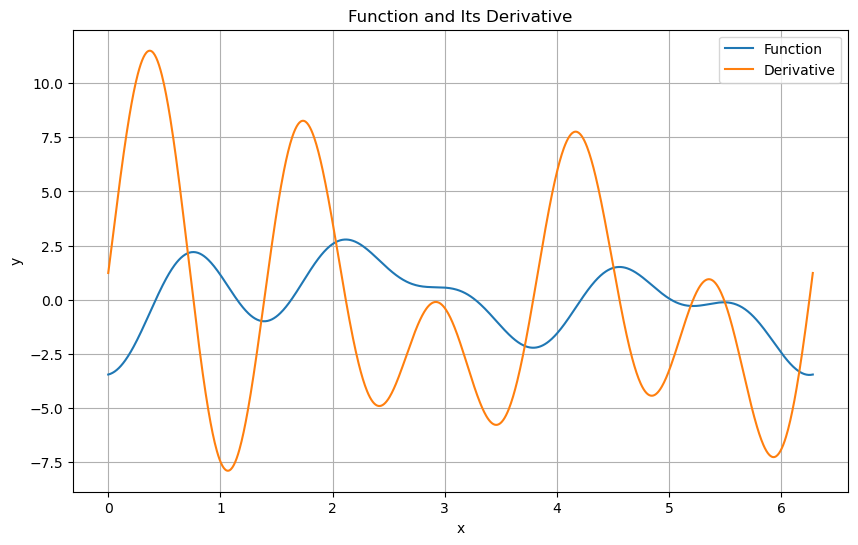

In [10]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [12]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [13]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [14]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [15]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [16]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [52]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None, log=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    if log:
        plt.yscale('log')

    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [18]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

criterion = torch.nn.MSELoss()

In [19]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [20]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [21]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [22]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [23]:
# train_losses, test_losses = model_training(L3ModelK3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results

In [24]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

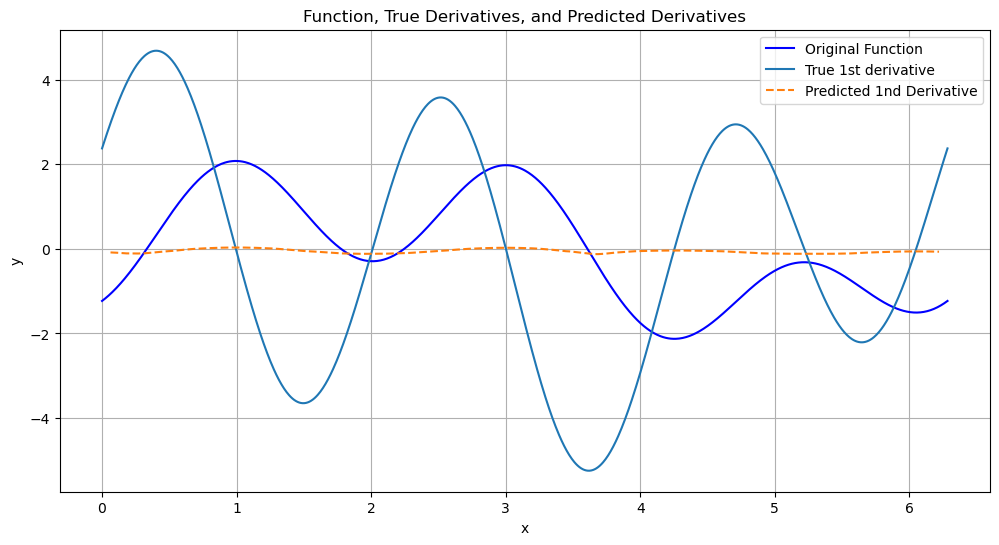

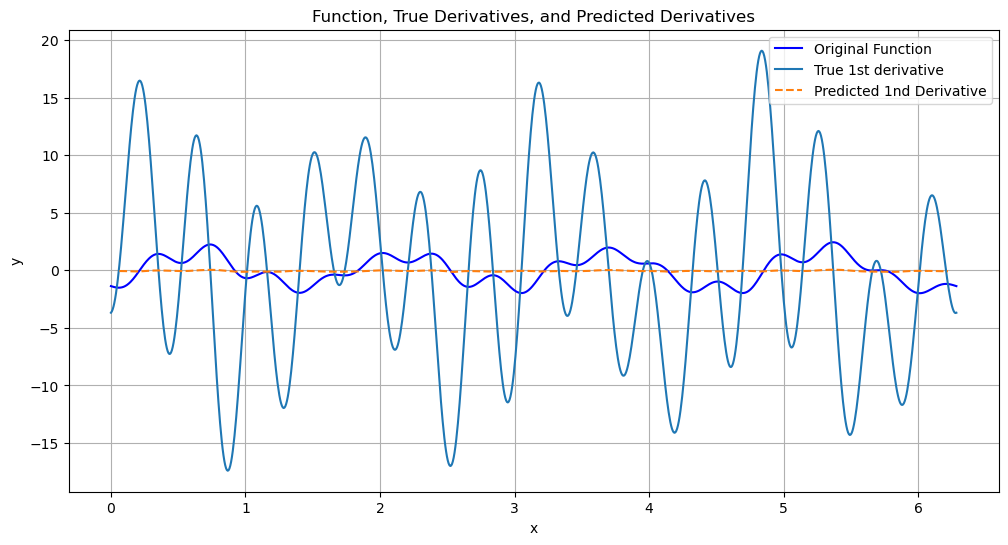

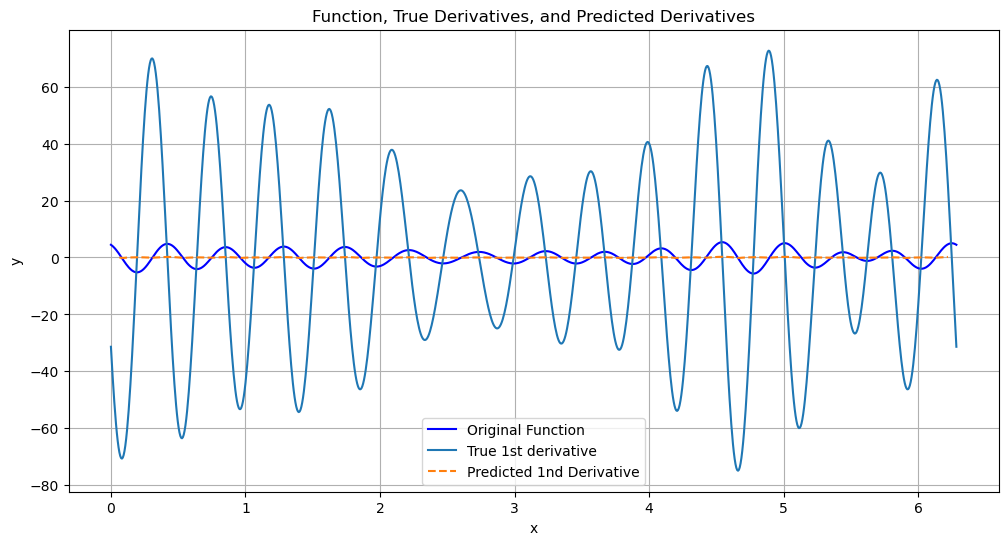

In [25]:
plot_all_outputs(L3ModelK3, model_name = 'L3ModelK3')

In [26]:
print_metrics(L3ModelK3)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9994645118713379
NMSE over high freq test functions: 0.9995222091674805


In [27]:
print(L3ModelK3)

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


**3 layer model with kernel size 9**

In [28]:
set_seed(seed)
L3ModelK9 = SimpleCNN(n_layers=3, kernel_size=9)

**Colormap**

In [29]:
def compute_fft_and_max_freq(dataloader, compute_output=False, model=None):
    fft_amplitudes = []
    max_frequencies = []
    T = 2 * torch.pi
    N = 1000

    # Calculate frequencies for the FFT
    frequencies = torch.fft.fftfreq(N, T / (2 * torch.pi * N))
    positive_freq_indices = frequencies >= 0
    positive_freqs = frequencies[positive_freq_indices]

    # Iterate over each batch
    for functions, _ in dataloader:  # Note that derivatives are ignored in this loop
        
        if compute_output:
            functions = model(functions.unsqueeze(1)).squeeze()
            # output = model(functions)
            
            # output = output.squeeze()
            # functions = output # set this so that the FFTs can be computed in the next line
        
        # Compute FFT using PyTorch
        F = torch.fft.fft(functions)
        magnitudes = torch.abs(F) / N

        # Consider only positive frequencies
        positive_magnitudes = magnitudes[:, positive_freq_indices]

        fft_amplitudes.append(positive_magnitudes)
        
        # Maximum frequency based on the highest amplitude for each function in the batch
        max_indices = torch.argmax(positive_magnitudes, dim=1)
        batch_max_freqs = positive_freqs[max_indices]
        max_frequencies.extend(batch_max_freqs)

    return torch.vstack(fft_amplitudes), torch.tensor(max_frequencies), positive_freqs

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xmin=0, xmax=0):
    fft_amplitudes = fft_amplitudes.detach().numpy()
    max_frequencies = max_frequencies.detach().numpy()
    freqs = freqs.detach().numpy()
    
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(-max_frequencies)  # Sort in descending order
    sorted_fft = fft_amplitudes[sorted_indices]

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)])
    plt.colorbar(im, label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim([xmin, xmax])
    plt.show()


In [30]:
def plot_heatmaps(model):
    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_dataloader,\
        compute_output=True, model=model)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Low freq model outputs', xmin=0, xmax=6)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(general_freq_dataloader,\
        compute_output=True, model=model)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='General freq model outputs', xmin=0, xmax=16)

    fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(high_freq_dataloader,\
        compute_output=True, model=model)
    plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='High freq model outputs', xmin=10, xmax=16)


## Experiments with training on different datasets

### Training on low frequency dataset only

Epoch [1/1000], Train Loss: 18.2070, Test Loss: 19.8364
Epoch [2/1000], Train Loss: 17.6018, Test Loss: 19.0469
Epoch [3/1000], Train Loss: 16.8705, Test Loss: 17.5878
Epoch [4/1000], Train Loss: 15.0755, Test Loss: 15.2844
Epoch [5/1000], Train Loss: 12.2700, Test Loss: 12.1578
Epoch [6/1000], Train Loss: 9.3730, Test Loss: 8.5233
Epoch [7/1000], Train Loss: 6.4256, Test Loss: 5.7314
Epoch [8/1000], Train Loss: 4.4227, Test Loss: 3.9036
Epoch [9/1000], Train Loss: 3.0916, Test Loss: 2.9888
Epoch [10/1000], Train Loss: 2.5879, Test Loss: 2.5429
Epoch [11/1000], Train Loss: 2.2051, Test Loss: 2.3335
Epoch [12/1000], Train Loss: 2.0987, Test Loss: 2.1826
Epoch [13/1000], Train Loss: 2.0079, Test Loss: 2.0520
Epoch [14/1000], Train Loss: 1.8810, Test Loss: 1.8924
Epoch [15/1000], Train Loss: 1.7296, Test Loss: 1.7649
Epoch [16/1000], Train Loss: 1.6409, Test Loss: 1.6577
Epoch [17/1000], Train Loss: 1.4926, Test Loss: 1.5318
Epoch [18/1000], Train Loss: 1.4019, Test Loss: 1.4257
Epoch [19

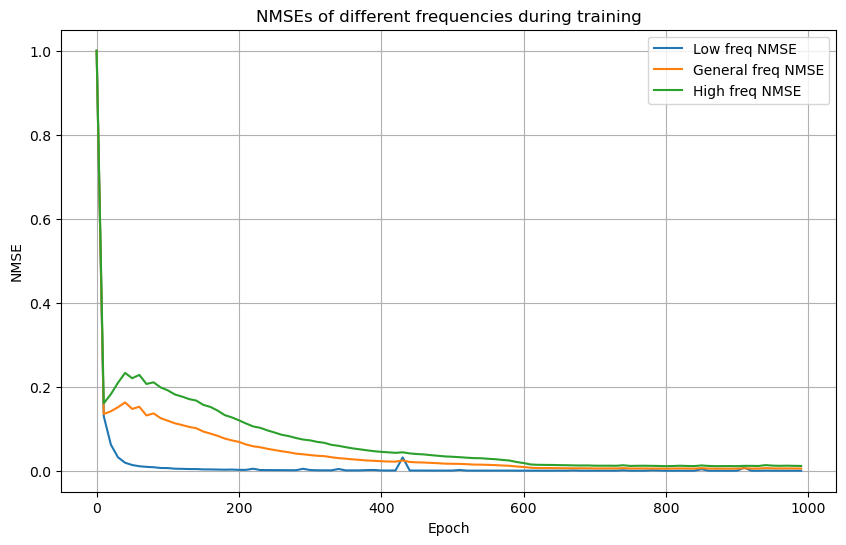

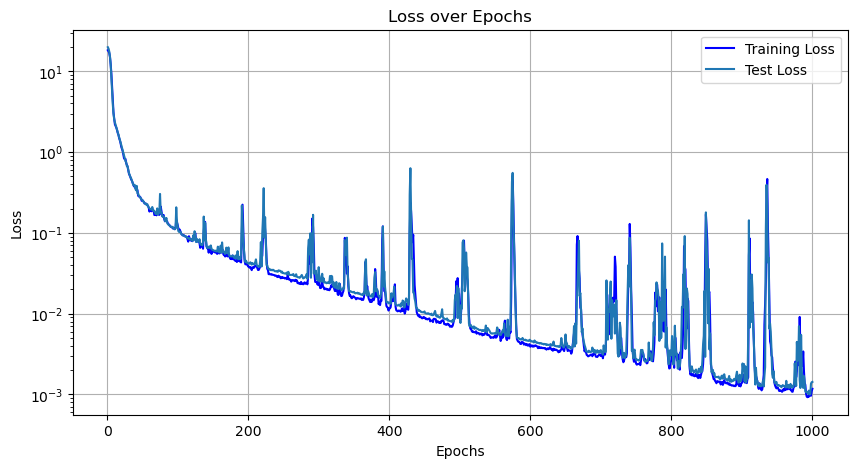

In [31]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [32]:
print_metrics(L3ModelK3_low)

NMSE over low freq test functions: 7.050673593766987e-05
NMSE over general freq test functions: 0.005851656664162874
NMSE over high freq test functions: 0.011258137412369251


### Training on high frequency data only

Epoch [1/1000], Train Loss: 1040.2950, Test Loss: 1046.9394
Epoch [2/1000], Train Loss: 1007.1825, Test Loss: 997.6084
Epoch [3/1000], Train Loss: 946.6959, Test Loss: 908.3425
Epoch [4/1000], Train Loss: 819.4355, Test Loss: 766.5535
Epoch [5/1000], Train Loss: 663.0668, Test Loss: 573.4212
Epoch [6/1000], Train Loss: 456.5904, Test Loss: 350.4054
Epoch [7/1000], Train Loss: 247.3039, Test Loss: 155.8414
Epoch [8/1000], Train Loss: 96.2206, Test Loss: 45.8510
Epoch [9/1000], Train Loss: 32.3505, Test Loss: 23.6348
Epoch [10/1000], Train Loss: 24.3562, Test Loss: 22.7738
Epoch [11/1000], Train Loss: 22.1994, Test Loss: 20.4432
Epoch [12/1000], Train Loss: 20.3498, Test Loss: 19.7209
Epoch [13/1000], Train Loss: 19.7737, Test Loss: 19.0492
Epoch [14/1000], Train Loss: 19.4669, Test Loss: 18.5502
Epoch [15/1000], Train Loss: 18.8565, Test Loss: 18.1747
Epoch [16/1000], Train Loss: 18.4181, Test Loss: 17.8570
Epoch [17/1000], Train Loss: 18.1964, Test Loss: 17.5472
Epoch [18/1000], Train 

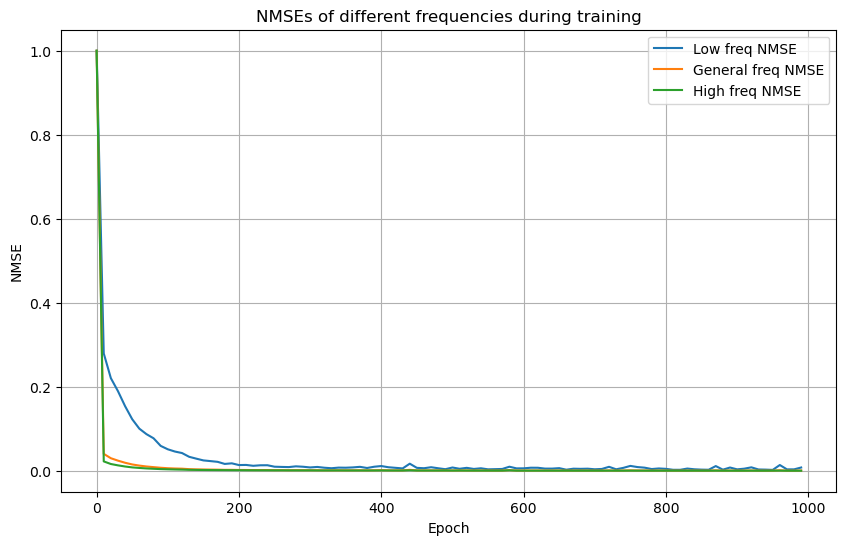

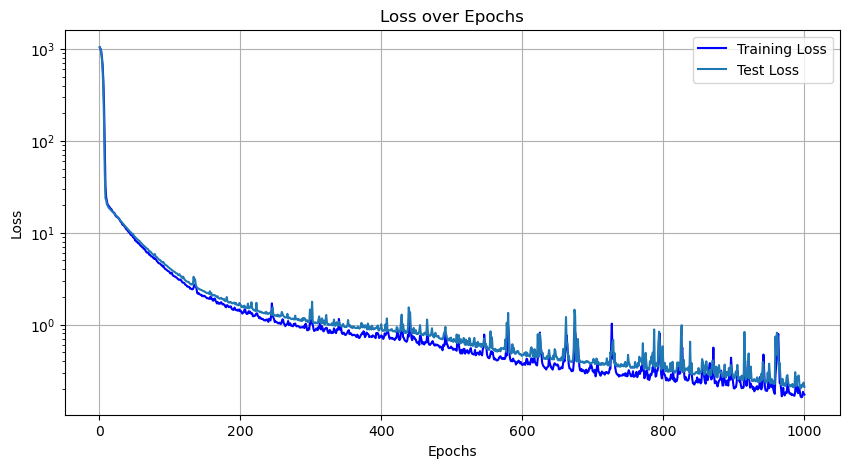

In [33]:
set_seed(seed)
L3ModelK3_high = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_high, train_dataloader_h, test_dataloader_h,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [34]:
print_metrics(L3ModelK3_high)

NMSE over low freq test functions: 0.0053541772067546844
NMSE over general freq test functions: 0.000422947749029845
NMSE over high freq test functions: 0.00019506702665239573


## Training for longer

### 3 layers 3 kernel 2000 epochs 
### Low freq dataset

Epoch [1/2000], Train Loss: 18.2070, Test Loss: 19.8364
Epoch [2/2000], Train Loss: 17.6018, Test Loss: 19.0469
Epoch [3/2000], Train Loss: 16.8705, Test Loss: 17.5878
Epoch [4/2000], Train Loss: 15.0755, Test Loss: 15.2844
Epoch [5/2000], Train Loss: 12.2700, Test Loss: 12.1578
Epoch [6/2000], Train Loss: 9.3730, Test Loss: 8.5233
Epoch [7/2000], Train Loss: 6.4256, Test Loss: 5.7314
Epoch [8/2000], Train Loss: 4.4227, Test Loss: 3.9036
Epoch [9/2000], Train Loss: 3.0916, Test Loss: 2.9888
Epoch [10/2000], Train Loss: 2.5879, Test Loss: 2.5429
Epoch [11/2000], Train Loss: 2.2051, Test Loss: 2.3335
Epoch [12/2000], Train Loss: 2.0987, Test Loss: 2.1826
Epoch [13/2000], Train Loss: 2.0079, Test Loss: 2.0520
Epoch [14/2000], Train Loss: 1.8810, Test Loss: 1.8924
Epoch [15/2000], Train Loss: 1.7296, Test Loss: 1.7649
Epoch [16/2000], Train Loss: 1.6409, Test Loss: 1.6577
Epoch [17/2000], Train Loss: 1.4926, Test Loss: 1.5318
Epoch [18/2000], Train Loss: 1.4019, Test Loss: 1.4257
Epoch [19

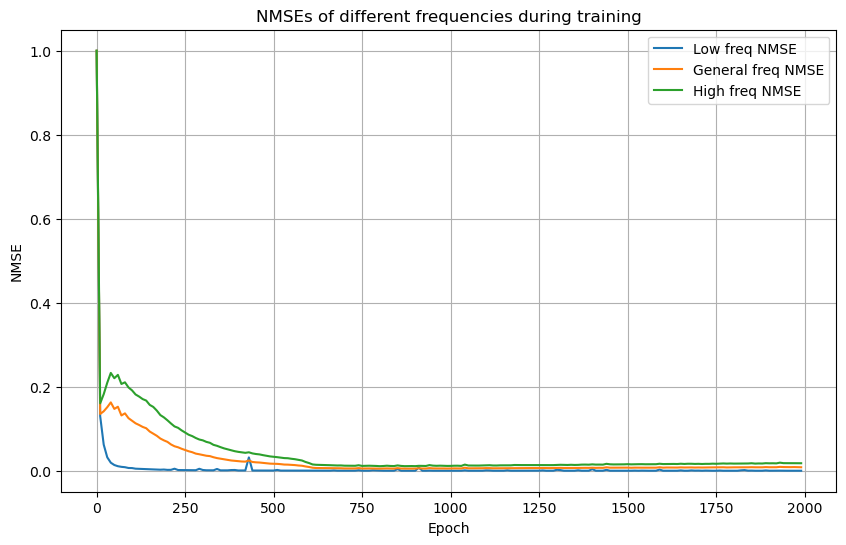

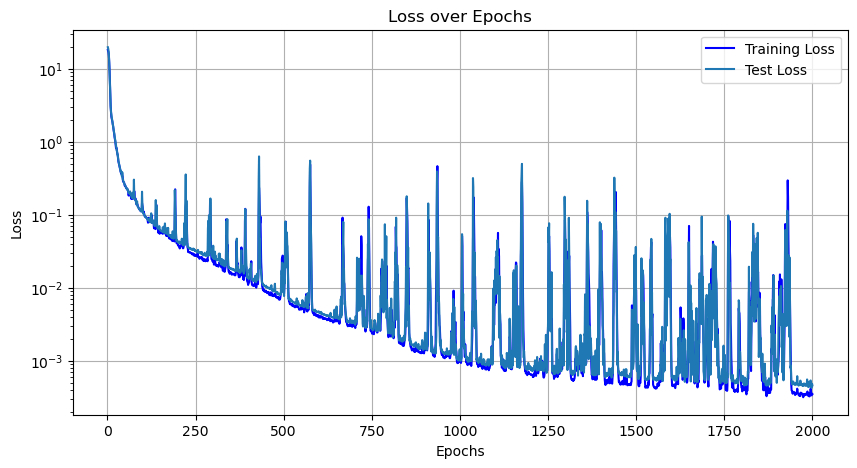

NMSE over low freq test functions: 2.256430161651224e-05
NMSE over general freq test functions: 0.008973238058388233
NMSE over high freq test functions: 0.017405031248927116


In [41]:
set_seed(seed)
L3ModelK3_low = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_low, train_dataloader_l, test_dataloader_l,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

print_metrics(L3ModelK3_low)

In [49]:
# Percent difference:
(0.017405031248927116 - 2.256430161651224e-05)/(2.256430161651224e-05)

770.3525348460313

### High freq dataset

Epoch [1/2000], Train Loss: 1040.2950, Test Loss: 1046.9394
Epoch [2/2000], Train Loss: 1007.1825, Test Loss: 997.6084
Epoch [3/2000], Train Loss: 946.6959, Test Loss: 908.3425
Epoch [4/2000], Train Loss: 819.4355, Test Loss: 766.5535
Epoch [5/2000], Train Loss: 663.0668, Test Loss: 573.4212
Epoch [6/2000], Train Loss: 456.5904, Test Loss: 350.4054
Epoch [7/2000], Train Loss: 247.3039, Test Loss: 155.8414
Epoch [8/2000], Train Loss: 96.2206, Test Loss: 45.8510
Epoch [9/2000], Train Loss: 32.3505, Test Loss: 23.6348
Epoch [10/2000], Train Loss: 24.3562, Test Loss: 22.7738
Epoch [11/2000], Train Loss: 22.1994, Test Loss: 20.4432
Epoch [12/2000], Train Loss: 20.3498, Test Loss: 19.7209
Epoch [13/2000], Train Loss: 19.7737, Test Loss: 19.0492
Epoch [14/2000], Train Loss: 19.4669, Test Loss: 18.5502
Epoch [15/2000], Train Loss: 18.8565, Test Loss: 18.1747
Epoch [16/2000], Train Loss: 18.4181, Test Loss: 17.8570
Epoch [17/2000], Train Loss: 18.1964, Test Loss: 17.5472
Epoch [18/2000], Train 

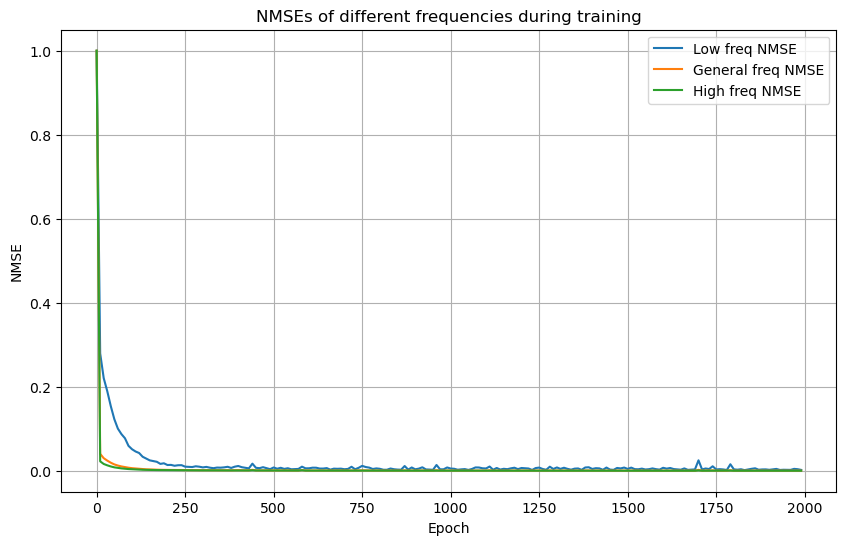

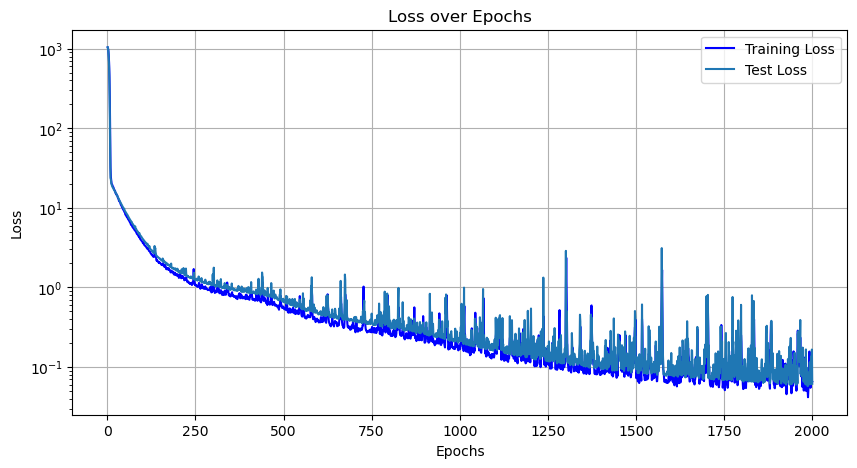

NMSE over low freq test functions: 0.00300872721709311
NMSE over general freq test functions: 0.00019420239550527185
NMSE over high freq test functions: 5.7198987633455545e-05


In [44]:
set_seed(seed)
L3ModelK3_high = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_high, train_dataloader_h, test_dataloader_h,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

print_metrics(L3ModelK3_high)

In [48]:
# percent difference
(0.00300872721709311 - 5.7198987633455545e-05) / (5.7198987633455545e-05)

51.601057144118286

**Training on the high frequency dataset leads to a smaller (better) performance difference on the low frequency data: it's about two orders of magnitude difference when training on the high frequency data vs three orders of magnitude difference when training on the low frequency data.**

### General frequency data

Epoch [1/2000], Train Loss: 440.8359, Test Loss: 364.8578
Epoch [2/2000], Train Loss: 420.8708, Test Loss: 347.7103
Epoch [3/2000], Train Loss: 397.4329, Test Loss: 316.2268
Epoch [4/2000], Train Loss: 344.7371, Test Loss: 267.0506
Epoch [5/2000], Train Loss: 280.6145, Test Loss: 199.2646
Epoch [6/2000], Train Loss: 195.8094, Test Loss: 120.8080
Epoch [7/2000], Train Loss: 104.3812, Test Loss: 55.0706
Epoch [8/2000], Train Loss: 42.6102, Test Loss: 19.3664
Epoch [9/2000], Train Loss: 18.3718, Test Loss: 12.4382
Epoch [10/2000], Train Loss: 15.0311, Test Loss: 12.0920
Epoch [11/2000], Train Loss: 14.3873, Test Loss: 11.2176
Epoch [12/2000], Train Loss: 13.8658, Test Loss: 10.8709
Epoch [13/2000], Train Loss: 13.1750, Test Loss: 10.5248
Epoch [14/2000], Train Loss: 12.8816, Test Loss: 10.2105
Epoch [15/2000], Train Loss: 12.6597, Test Loss: 9.9416
Epoch [16/2000], Train Loss: 12.1188, Test Loss: 9.6594
Epoch [17/2000], Train Loss: 11.7766, Test Loss: 9.4239
Epoch [18/2000], Train Loss: 1

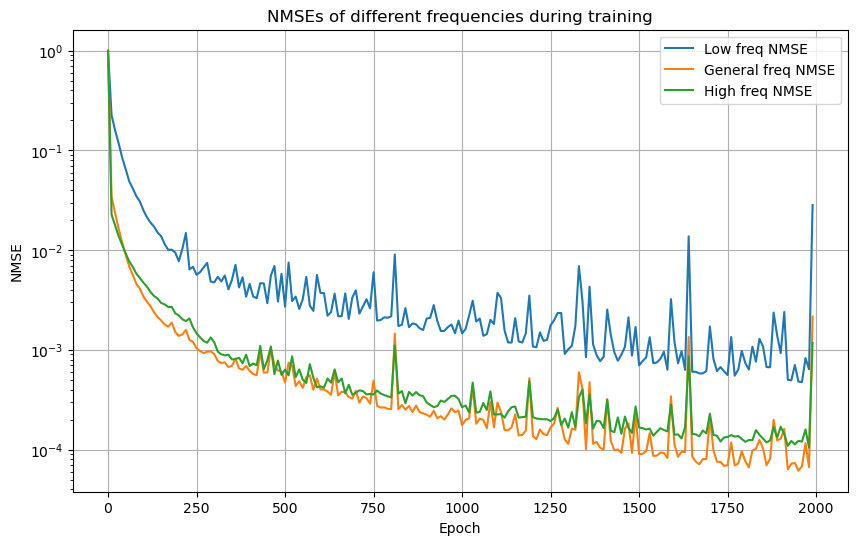

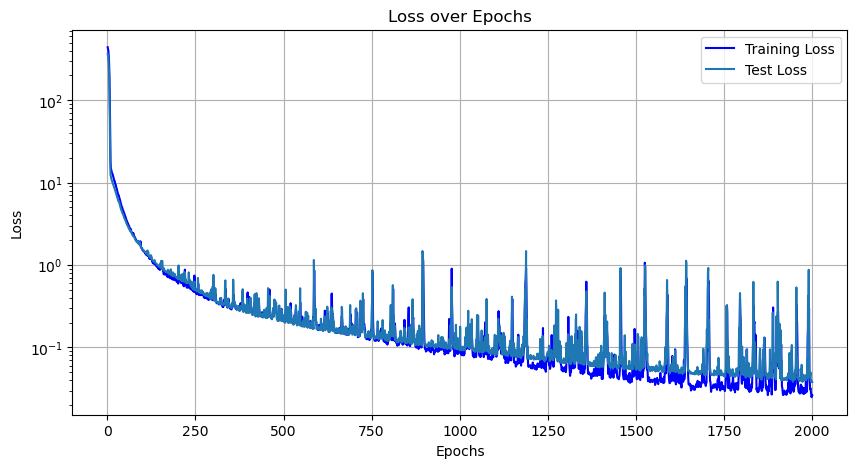

NMSE over low freq test functions: 0.00042287775431759655
NMSE over general freq test functions: 0.00010154847404919565
NMSE over high freq test functions: 0.00010992151510436088


In [53]:
set_seed(seed)
L3ModelK3_general = SimpleCNN(n_layers=3, kernel_size=3)

train_losses, test_losses = model_training(L3ModelK3_general, train_dataloader_g, test_dataloader_g,\
    num_epochs=2000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first', log=True)
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

print_metrics(L3ModelK3_general)

In [56]:
### Difference

(0.00042287775431759655 - 0.00010992151510436088) / 0.00010992151510436088

2.8470881147890936

### See model weights

In [59]:
L3ModelK3_general

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)

In [67]:
L3ModelK3_general.convs[0].weight

Parameter containing:
tensor([[[ 0.5872,  0.6052, -0.4130]],

        [[ 0.7475, -0.0532, -0.0728]],

        [[-0.5396,  0.4294,  0.6414]],

        [[-0.6480,  0.5928,  0.3060]],

        [[ 0.5506,  0.1938,  0.2579]],

        [[-0.0745,  0.6608,  0.0766]],

        [[-0.3429,  0.0562, -0.3712]],

        [[-0.2384, -0.2775,  0.5218]],

        [[-0.5445, -0.4239, -0.2043]],

        [[-0.3490, -0.0196, -0.6505]],

        [[ 0.7355, -0.5287,  0.5555]],

        [[ 0.3463, -0.3705,  0.4690]],

        [[-0.3901,  1.0459, -0.3648]],

        [[-0.2890,  0.0520, -0.2064]],

        [[ 0.2122,  0.6884,  0.2708]],

        [[-0.2403,  0.5218,  0.2158]],

        [[ 0.4169, -0.4557, -0.7121]],

        [[-0.2823, -0.3516,  0.6390]],

        [[ 0.2134,  0.3179,  0.1114]],

        [[ 0.1377,  0.4861, -0.6234]],

        [[-0.0162, -0.6077,  0.1027]],

        [[-0.3144,  0.0772, -0.1698]],

        [[ 0.5190, -0.5102, -0.4890]],

        [[-0.4983,  0.6912,  0.3260]],

        [[ 0.6384,

### Questions:
- Does training on high freq data lead to better performance on low freq data, or vice-versa? I.e., is the performance delta larger or smaller? 
    - Yes: training on high freq data leads to a smaller performance gap on the low freq data than vice-versa.
    - However, training on the general freq dataset leads to the best performance overall, **but there is a an opposite bias for some reason: high freq data has lower NMSE than low freq data, which is counterintuitive**
    - And, the general freq NMSE is almost identical to the high freq NMSE
- Need to plot the heatmap over epochs
- Is this happening because the **MSE** is larger for high freq data and therefore learning that better?
- Does changing the model architecture (layers or kernel size) change this bias?
- Can "fine-tuning" a model that was trained on high freq data with low freq data lead to better performance than just training on general freq?